In [2]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

## 1. Data Loading and Preprocessing

In [3]:
# Load data
customers_path = 'Customers.csv'
transactions_path = 'Transactions.csv'

customers_df = pd.read_csv(customers_path)
transactions_df = pd.read_csv(transactions_path)

# Aggregate transaction data
customer_metrics = transactions_df.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'mean', 'std'],
    'Quantity': ['sum', 'mean'],
    'TransactionID': 'count'
}).reset_index()

# Flatten column names
customer_metrics.columns = [
    'CustomerID', 'TotalSpend', 'AvgTransactionValue', 'SpendStd',
    'TotalQuantity', 'AvgQuantity', 'TransactionCount'
]

# Process customer data
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
customers_df['CustomerAge'] = (pd.Timestamp.now() - customers_df['SignupDate']).dt.days

# Merge data
merged_data = customers_df.merge(customer_metrics, on='CustomerID', how='left')

# Fill missing values
merged_data = merged_data.fillna({
    'TotalSpend': 0,
    'AvgTransactionValue': 0,
    'SpendStd': 0,
    'TotalQuantity': 0,
    'AvgQuantity': 0,
    'TransactionCount': 0
})

# One-hot encode Region
merged_data = pd.get_dummies(merged_data, columns=['Region'], prefix='Region')

print("Data loaded and preprocessed successfully!")

Data loaded and preprocessed successfully!


## 2. Feature Engineering and Scaling

In [4]:
# Select features
features = [
    'CustomerAge', 'TotalSpend', 'AvgTransactionValue', 'SpendStd',
    'TotalQuantity', 'AvgQuantity', 'TransactionCount'
] + [col for col in merged_data.columns if col.startswith('Region')]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(merged_data[features])

print(f"Features prepared: {', '.join(features)}")

Features prepared: CustomerAge, TotalSpend, AvgTransactionValue, SpendStd, TotalQuantity, AvgQuantity, TransactionCount, Region_Asia, Region_Europe, Region_North America, Region_South America


## 3. Clustering Analysis

In [6]:
# Initialize lists to store metrics
k_values = range(2, 11)
db_scores = []
silhouette_scores = []
calinski_scores = []
models = []

# Perform clustering for different k values
for k in k_values:
    # Fit KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    # Calculate metrics
    db_scores.append(davies_bouldin_score(X_scaled, labels))
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    calinski_scores.append(calinski_harabasz_score(X_scaled, labels))
    models.append((kmeans, labels))

# Find best model (lowest DB score)
best_idx = np.argmin(db_scores)
best_k = k_values[best_idx]
best_model, best_labels = models[best_idx]

print(f"Clustering completed. Best k = {best_k}")

Clustering completed. Best k = 8


## 4. Visualization

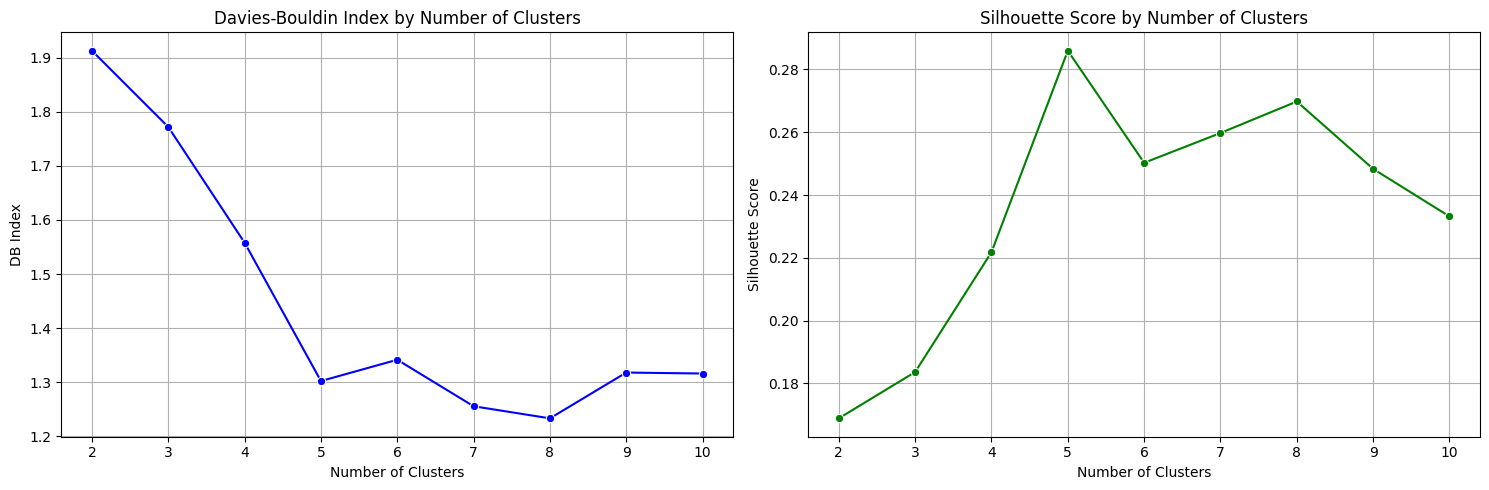

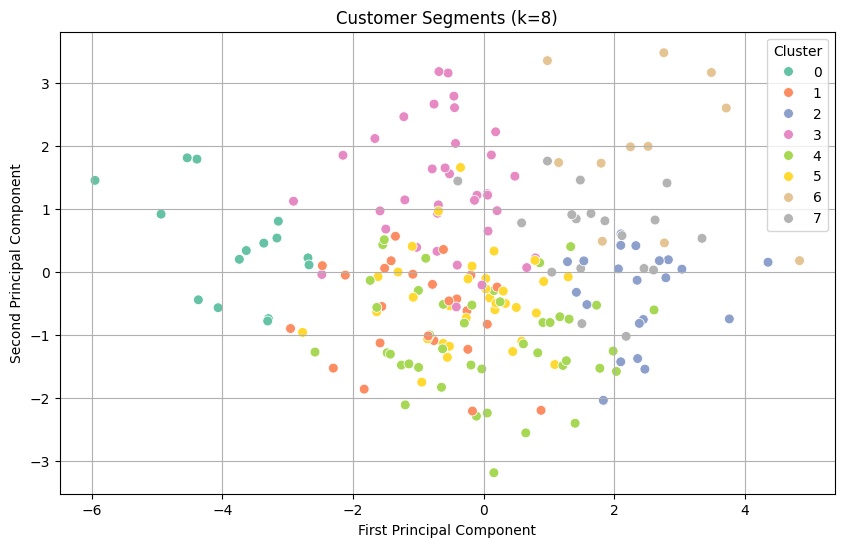

In [7]:
# Plot metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# DB Index
sns.lineplot(x=list(k_values), y=db_scores, marker='o', ax=ax1, color='blue')
ax1.set_title('Davies-Bouldin Index by Number of Clusters')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('DB Index')
ax1.grid(True)

# Silhouette Score
sns.lineplot(x=list(k_values), y=silhouette_scores, marker='o', ax=ax2, color='green')
ax2.set_title('Silhouette Score by Number of Clusters')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Silhouette Score')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Plot clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=best_labels, palette='Set2', s=50)
plt.title(f'Customer Segments (k={best_k})')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

## 5. Results and Metrics

In [8]:
print("Clustering Results:")
print(f"Number of Clusters: {best_k}")
print(f"\nMetrics for best clustering (k={best_k}):")
print(f"Davies-Bouldin Index: {db_scores[best_idx]:.4f}")
print(f"Silhouette Score: {silhouette_scores[best_idx]:.4f}")
print(f"Calinski-Harabasz Index: {calinski_scores[best_idx]:.4f}")

# Save results
merged_data['Cluster'] = best_labels
merged_data[['CustomerID', 'Cluster']].to_csv('customer_segments.csv', index=False)
print("\nResults saved to 'customer_segments.csv'")

Clustering Results:
Number of Clusters: 8

Metrics for best clustering (k=8):
Davies-Bouldin Index: 1.2331
Silhouette Score: 0.2698
Calinski-Harabasz Index: 39.7577

Results saved to 'customer_segments.csv'
